データの読み込み・標準化

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv
import math

# 時系列データを一次元配列に格納

data = np.genfromtxt("lorentz-1dim.csv",  # ファイルのパス
)



# 平均と標準偏差の計算
mean_value = np.mean(data)
std_dev = np.std(data)

# 標準化
data = (data - mean_value) / std_dev


print('Data length:',data.size)

Data length: 5000


ハイパーパラメータの設定

In [93]:
new_lag = 3#データを間引く間隔・低い値が良さそう。
new_dim = 5#間引いた後に取得する「パターン列」の長さ



T_0 = 4460#トレーニングデータとテストデータとの境目

#T_trainの値は、T_0からnew_dim*new_lagを引いた値以上に小さくないといけない。

T_train = 4230#T_0から過去に対するデータの長さ
T_test = 250#T_0から未来に対するデータの長さ



# 分割数を指定
"""
パターン数が増えなくなるまでどんどん値を増やしてよい（計算時間が許す限り）。
"""

n_bins = 600 #分割数・PDFを使って、値が密集している所の分割数を増やす。


#活性化関数のシャープ度
sigma=0.1
#0.1くらいとると定数に落ちるものが復活したことがある。

データの加工・データを間引く

In [94]:
# 推定の時の初期値分だけ間引く
shortened_data = data[T_0-T_train-new_dim*new_lag:T_0-new_dim*new_lag]

# データをnew_lag間隔で間引く
data_thinned = shortened_data[::new_lag]


#推定の時の初期値データを確保
data_subset = data[T_0-new_dim*new_lag:T_0:new_lag]

累積分布関数を使って値域を離散化する

In [95]:
# 累積分布関数（CDF）を計算
cdf_values, bin_edges = np.histogram(data_thinned, bins='auto', density=True)
cdf_values = np.cumsum(cdf_values)

# 等間隔に分割された確率値を生成
probability_values = np.linspace(0, 1, n_bins + 1)

# 逆CDFを計算して、n_bins個の横軸の値を得る
inverse_cdf_values = np.interp(probability_values, cdf_values / cdf_values[-1], bin_edges[:-1])

代数的学習に際して必要な関数をここにまとめる。

In [96]:
from collections import Counter, defaultdict


##パターン抽出とその次の値に対する関数

def extract_patterns_and_next_values(time_series_data, new_dim):
    patterns = []
    next_values = defaultdict(list)
    num_patterns = len(time_series_data) - new_dim
    for i in range(num_patterns):
        pattern = tuple(time_series_data[i:i+new_dim])  # パターンをタプルとして抽出
        next_value = time_series_data[i+new_dim]  # パターンの次の値を取得
        patterns.append(pattern)
        next_values[pattern].append(next_value)
    return patterns, next_values

##最も頻度の高い「次の値」を指定する。

def assign_most_frequent_next_value_to_patterns(next_values):
    assigned_values = {}
    for pattern, values in next_values.items():
        counts = Counter(values)
        most_common_value = counts.most_common(1)[0][0]
        assigned_values[pattern] = most_common_value
    return assigned_values

##データを離散値にフィットさせる。

def discretize_time_series(data, discretized_values):
    discretized_data = []
    for value in data:
        # 各データポイントと離散値との距離を計算し、最も近い離散値を割り当てる
        nearest_value = min(discretized_values, key=lambda x: abs(x - value))
        discretized_data.append(nearest_value)
    return discretized_data

代数的学習を以下で進める

In [97]:
# 離散値の設定
discretized_values = inverse_cdf_values

# サンプルの時系列データ
time_series_data = data_thinned

#初期化

discretized_data= None
pattens =None
next_values = None
assigned_values = None

# データを離散値にフィットさせる
discretized_data = np.array(discretize_time_series(time_series_data, discretized_values))

# パターンと最頻出の次の値の割り当て
patterns, next_values = extract_patterns_and_next_values(discretized_data, new_dim)

出力結合重みベクトルの生成

In [98]:
#パターンをまとめた行列を生成
tuples = assign_most_frequent_next_value_to_patterns(next_values)
matrix = [list(t) for t in tuples]


def generate_vectors(assigned_values):
    vectors = []
    for pattern, next_value in assigned_values.items():
        vectors.append([next_value])
    return vectors


# ベクトルの生成（出力結合重みベクトル）
vectors = generate_vectors(tuples)

リカレント結合重み行列生成の準備・行列の掛け算自体に活性化関数を組み込む

In [99]:
#活性化関数の定義
def one_to_one_zero_to_zero0(data):#ガウス関数に設定
 #   return 1 if math.isclose(data, 1) else 0
     return  math.exp(-(sigma*(data - 1)**2))

#リカレント結合重み行列を生成するための関数
def matrix_vector_product(A, v):


    result = np.zeros((A.shape[0], 1))  # 結果を格納する空の列ベクトルを作成

    # 行列とベクトルの積の計算
    for i in range(A.shape[0]):  # 行数に対してループ
        for j in range(A.shape[1]):  # 列数に対してループ
            result[i] += one_to_one_zero_to_zero0(A[i][j] * v[j])
              # 行列の各行の要素とベクトルの対応する要素の積を計算し、その結果を加算

    return result

# 各成分を逆数に変換する
inverse_matrix = [[1 / element for element in row] for row in matrix]

# 逆数の行列の設定
A = np.array(inverse_matrix)

外側の活性化関数・ここもガウス関数を使う

In [100]:
def vector_one_to_one_zero_to_zero(vector, new_dim, sigma):
    result = []
    for x in vector:
        if isinstance(x, list):
            result.append(vector_one_to_one_zero_to_zero(x, new_dim))
        else:
             result.append( math.exp(-(sigma *(x - new_dim)**2)))
    return result


## 最大値のみを1とし、それ以外をゼロとする操作
def max_to_one(vector):
    max_index = np.argmax(vector)  # 最大値を持つ列のインデックスを取得
    result = np.zeros_like(vector)  # ゼロで初期化された同じサイズの配列を作成
    result[max_index] = 1  # 最大値を持つ列を1に設定
    return result

推定に対する初期値を生成

In [101]:
def discretize_time_series(data, discretized_values):
    discretized_data = []
    for value in data:
        # 各データポイントと離散値との距離を計算し、最も近い離散値を割り当てる
        nearest_value = min(discretized_values, key=lambda x: abs(x - value))
        discretized_data.append(nearest_value)
    return discretized_data

discretized_initial_data = discretize_time_series(data_subset, discretized_values)

#print(np.array(discretized_initial_data))

以下はすべてを組み込んだ漸化式（推定段階）

In [102]:
%%time
def generate_time_series(length, new_dim, inverse_matrix, vectors, sigma):
    time_series = discretized_initial_data
    for _ in range(new_dim, length):
        # 行列の掛け算を実行
       result = np.dot(max_to_one(np.array(vector_one_to_one_zero_to_zero(matrix_vector_product
        (A, np.array(time_series[-new_dim:])),new_dim, sigma))), np.array(vectors))
        # 結果をtime_seriesに追加
       time_series.append(result[0])
    return time_series

##データを間引いているので、テストさせる長さをそれに合わせる
predict_length = int(T_test/new_lag+new_dim)

#初期値を使って推定データを生成する
time_series_data = generate_time_series(predict_length, new_dim, inverse_matrix, vectors, sigma)

<ipython-input-100-7f182b9386f4>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result.append( math.exp(-(sigma *(x - new_dim)**2)))


CPU times: user 2.98 s, sys: 13 ms, total: 2.99 s
Wall time: 3.03 s


可視化のため、グラフを滑らかにする。

In [103]:
import numpy as np

def right_half_ones(window_size):


    kernel = np.zeros(window_size)
    half_index = int(window_size/2+1)
    kernel[:half_index] = 1
    return kernel



# 拡張後のデータを格納するリスト
expanded_data = []

# 元のデータを展開して挿入
for value in time_series_data:
    expanded_data.extend([value] * new_lag)


##合成積を三回施すことで滑らかになったので、愚直に三回施している。
window_size = new_lag
smoothed0_data = np.convolve(expanded_data, right_half_ones(window_size)/np.count_nonzero(right_half_ones(window_size)), mode='same')
smoothed1_data = np.convolve(smoothed0_data, right_half_ones(window_size)/np.count_nonzero(right_half_ones(window_size)), mode='same')
smoothed2_data = np.convolve(smoothed1_data, right_half_ones(window_size)/np.count_nonzero(right_half_ones(window_size)), mode='same')
smoothed_data = np.convolve(smoothed2_data, right_half_ones(window_size)/np.count_nonzero(right_half_ones(window_size)), mode='same')

データの可視化

パターン数:
1405


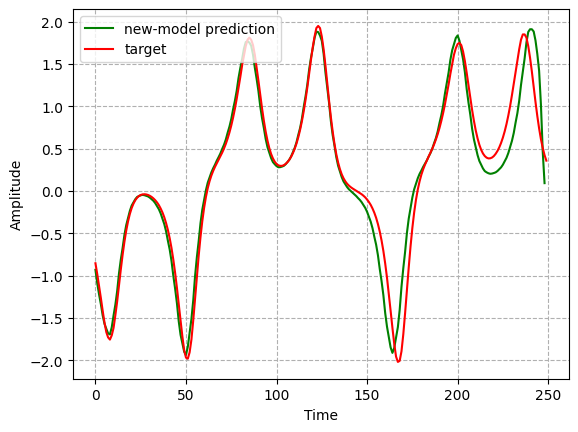

In [104]:


test_smooth=np.array(smoothed_data[new_dim*new_lag::])

xd =np.array(data[T_0:T_0+T_test:])

#####################


# テスト予測の実行
plt.plot(test_smooth,  color = "green",label="new-model prediction")
plt.plot(xd, color = "red",label="target")


# 拡張後のデータを格納するリスト
expanded_initial_data = []

# 元のデータを展開して挿入
for value in discretized_initial_data:
    expanded_initial_data.extend([value] * new_lag)


plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')
print("パターン数:")
print(len(vectors))

plt.show()